In [1]:
# Autoreload changed python modules
%load_ext autoreload

In [2]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
import cs230_project_utilities as utils
# make sure you have pywt: pip3 install PyWavelets --user

# Loading the data

In [5]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
dataset_directory = '/scratch/groups/mwinterm/BoostMRI/data/H5Exports_AnimiX'

In [6]:
# Find all the files in our dataset
files = utils.automap.find_dataset_files(dataset_directory)

Found 133 .h5 files and 133 .txt files.


# Visualizing the data

In [7]:
files.keys()

dict_keys(['1654_19895', '711_7280', '1498_18958', '709_7273', '1499_18472', '703_7368', '336_3848', '722_7090', '1499_18290', '723_7287', '710_7276', '709_7204', '1497_18746', '702_7265', '1670_20006', '710_7207', '977_11071', '1669_20022', '1498_18964', '1655_19289', '1655_22482', '977_11593', '1655_20205', '724_7391', '1497_18752', '1654_20177', '1498_18959', '724_7094', '711_7067', '977_12422', '1655_20200', '704_7221', '711_7212', '1654_19891', '1497_18747', '702_7365', '1669_22498', '722_7284', '1499_18353', '703_7051', '1670_20007', '1669_20023', '1654_20183', '1654_19886', '1655_19285', '711_7381', '1669_20018', '1654_20178', '1655_22478', '1655_20201', '1499_18343', '977_11980', '704_7270', '1669_20013', '723_7388', '1654_19892', '1497_18748', '1655_20198', '1669_22499', '722_7384', '1499_18405', '703_7218', '1670_20008', '943_10158', '1669_20024', '1654_20184', '1654_19887', '1655_22484', '1670_20003', '702_7048', '1499_18381', '1498_18961', '1669_20019', '1669_22508', '709_7

In [8]:
# Finally, we can see the raw data
h5 = files['724_7094']['h5']
h5_data = utils.automap.read_h5_file(h5)
print(h5_data.keys())

images = h5_data['images']
magnitude = h5_data['magnitude']
phase = h5_data['phase']
classification = h5_data['classification']

# (Note: shape of magnitude and phase are different from image)
print(images.shape, magnitude.shape, phase.shape)
print(np.ndarray.flatten(classification))

(15, 256, 256)
dict_keys(['classification', 'images', 'magnitude', 'phase'])
(15, 256, 256) (15, 256, 240) (15, 256, 240)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


/home/users/awal/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


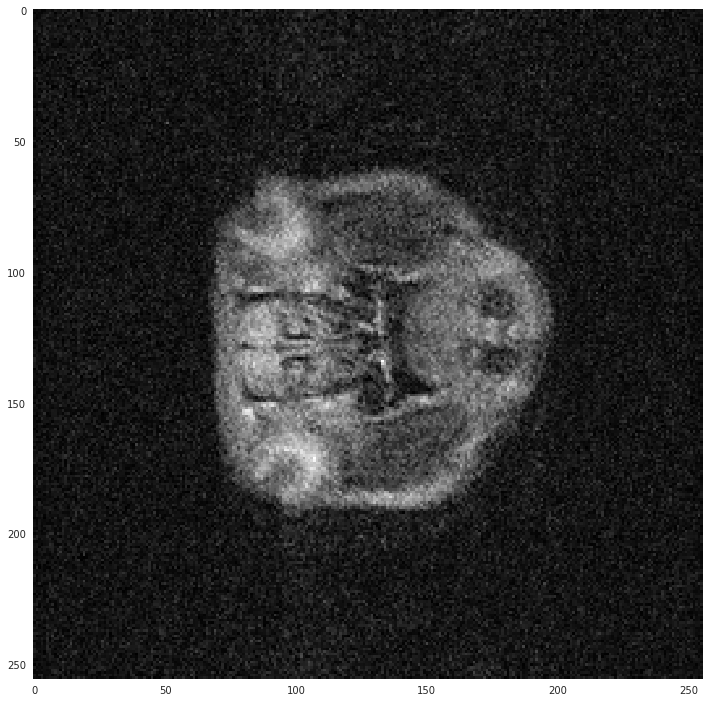

In [9]:
utils.plot.imshowgray(images[0])

In [10]:
np.pi

3.141592653589793

/home/users/awal/cs230-project/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


Error in FFT magnitude: 1.8354682870141233e-19
Error in FFT phase: 1.5035561514171795e-05


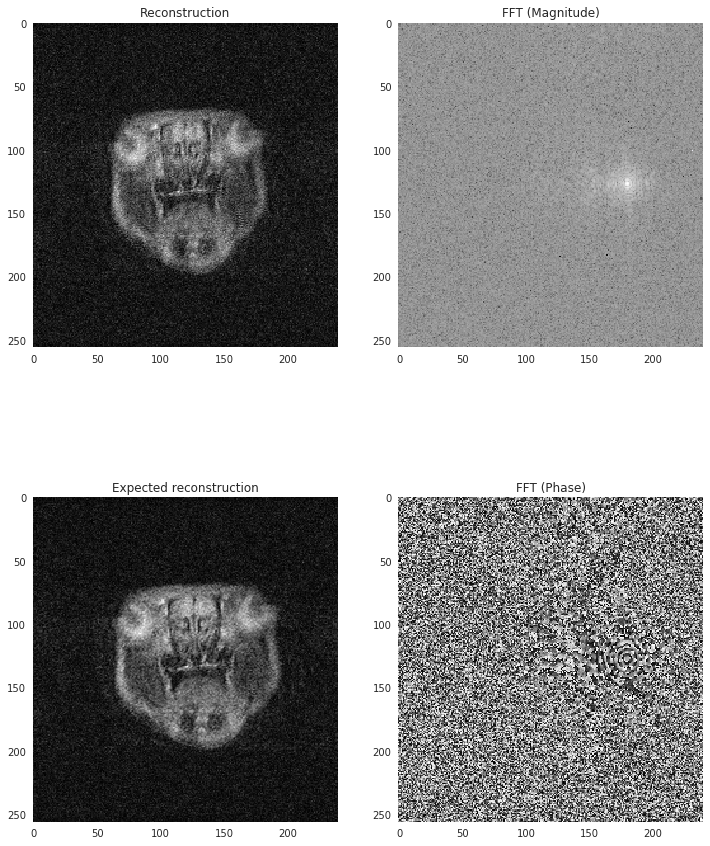

In [12]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[0] * np.exp(1j * phase[0])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))
# 
plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
image = utils.automap.transform_training_set_image_to_match_automap_output(images[0])
utils.plot.imshowgray(image)

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[0])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[0])))

# Automap Model

In [10]:
import keras
from keras.layers import Input,Conv2D, Conv2DTranspose, Dense, Reshape, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras import losses

Using TensorFlow backend.


In [11]:
def load_model():
    res=64
    X = Input((res,res,2))
    X1 = Flatten()(X)
    fc1 = Dense(res * res * 2, activation = 'tanh')(X1)
    fc2 = Dense(res * res, activation = 'tanh')(fc1)
    fc3 = Dense(res * res, activation = 'tanh')(fc2)
    X2 = Reshape((res, res, 1))(fc3)
    conv1_1 = Conv2D(64, 5, activation='relu', padding='same')(X2)
    conv1_2 = Conv2D(64, 5, activation='relu', padding='same')(conv1_1)
    conv1_3 = Conv2DTranspose(64, 9, activation='relu', padding='same')(conv1_2)
    out = Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3)
    model=Model(inputs=X, outputs=out)
    model.compile(optimizer=RMSprop(lr=1e-5), loss='mean_squared_error')
    return model

In [12]:
model = load_model()

Instructions for updating:
Colocations handled automatically by placer.
